# Spark-MLlib-音乐类服务用户流失预测

**项目概述**

针对音乐类服务的用户的行为数据，使用spark进行建模分析，预测哪些用户可能流失、哪些用户会降级服务(从付费到免费)，或者这取消服务。如果能预测出这些用户，通过打折已激励的方式留住他们，以挽救数百万的营业额。

本次使用一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。

**问题描述**

* 使用的数据集较小，存在样本数不足的可能
* 数据需要汇总、清理、探索、特征提取
* 建模前需要归一化数据

**评估指标**

* 准确率Accuracy
* F1值

**用户流失指标定义**

其中事件：Cancellation Confirmation 定义为用户流失(用户取消服务)事件，也是本次预测的label值, 1 代表取消服务，0 代表为取消服务。

**主要步骤如下**

1. 清理数据
2. 探索数据
    * 探索如下特征对用户是否取消服务的影响
        * 用户点赞、踩
        * 添加好友
        * 添加歌曲
        * 听歌频率
        * 设置功能
        * 使用设备
        * 注册时长
        * 升级、降级
        * 访问Home、About、Help次数
        * Error次数
        * 查看滚动广告的次数
3. 特征工程
    * 统计用户访问page页全量行为数据
    * 计算用户注册时长(单位：天)、经常使用设备类型
    * 探索获取用户流失最多的时段(子集)，统计这个时段内的用户行为数据
    * 计算子集对应page访问行为相对于总page访问行为占比
    * 标准化数据
    * one-hot
4. 建模
    * 使用GBTClassifier 梯度提升决策树 建模预测
    * 参数使用默认参数
    * 评估指标 Accuracy、F1-Score

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Row

from pyspark.sql.functions import avg, col, isnan, concat,count, desc, \
            explode, lit, sum, min, max, split, stddev, udf, \
            to_timestamp, date_sub
from pyspark.sql.types import IntegerType, StringType, LongType, DateType, DoubleType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA
from pyspark.ml.feature import RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import datetime
# first pip install device_detector analyze userAgent
from device_detector import DeviceDetector
# first pip install httpagentparser
import httpagentparser


In [2]:
# create a Spark session
spark = SparkSession.builder \
            .appName('predict_user_loss') \
            .getOrCreate()

In [3]:
# show config info
spark.sparkContext.getConf().getAll()
spark

# 加载和清洗数据
 
1. 统计每个列null统计、并删除firstName为空的8346行数据
    * (firstName, lastName, location, registration, userAgent) null值都是 8346行，对应的page为：Logout 、Submit Registration、Login、Register，所以可以删除这些行
2. 删除2列: artist、song
    * 列artist、song列空值58392个，这是正常情况，因为用户浏览Home/About等列没有歌曲名和歌曲作者，这两行不参与建模
3. timestamp列格式转换
    * 涉及列：ts, registration
3. 根据userAgent列生成 设备信息列 值为：(设备、浏览器、系统类型)


In [4]:
user_log = spark.read.json('mini_sparkify_event_data.json')

### 1. 统计每个列null统计、并删除

In [5]:
# total items/ total users/ total users with 'Cancellation Confirmation'
print(f"Total rows: {user_log.count()}")
print(f"Total users: {user_log.select('userId').dropDuplicates().count()}")
print(f"Total users with 'Cancellation Confirmation': {user_log.filter(user_log.page=='Cancellation Confirmation').select('userId').dropDuplicates().count()}")

Total rows: 286500
Total users: 226
Total users with 'Cancellation Confirmation': 52


In [6]:
user_log.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in user_log.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



### 删除8346行数据

删除的事件包括: Row(page='Submit Registration'), Row(page='Login'), Row(page='Register'),

In [7]:
user_log = user_log.filter( "firstName is not null")
user_log.count()

278154

## 删除列(artist, song)

In [8]:
user_log = user_log.drop(*('artist', 'song'))

### 生成设备信息列 deviceModel

In [9]:
#get_device_model = udf(lambda ua: httpagentparser.detect(ua)['dist']['name'])
#get_deviec_model = udf(lambda ua : DeviceDetector(ua).parse().os_name())
def get_device_model(userAgent):
    device = httpagentparser.detect(userAgent)
    if "dist" in device.keys():
        return device["dist"]["name"]
    elif "browser" in device.keys():
        return device["browser"]["name"]
    elif "platform" in device.keys():
        return device["platform"]["name"]
udf_get_device_model = udf(get_device_model, StringType())
user_log = user_log.withColumn("deviceModel", udf_get_device_model(user_log.userAgent))

In [10]:
user_log.printSchema()

root
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- deviceModel: string (nullable = true)



## timestamp to date 格式

In [11]:
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
# convert ts and registration date format
user_log = user_log.withColumn("ts_date", get_timestamp(user_log.ts))
user_log = user_log.withColumn("regist_date", get_timestamp(user_log.registration))

In [12]:
user_log.createOrReplaceTempView('user_log_table')

# 定义客户流失

创建一列 `label` 作为模型的标签。使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。同时也可以深入了解 `Downgrade` 事件。

# 探索数据
执行一些探索性数据分析，观察留存用户和流失用户的行为。首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

### 结论
1. 使用Setting多的用户，越不容易取消服务, 说明用户乐于使用产品
2. 使用Ubuntu取消服务偏多、iPad使用人取消服务人相对较少
3. 取消服务的人明显听歌数量也偏少
4. 查看滚动广告越多的，越容易取消服务
5. 越少的降级发生越好
6. 点赞越少的用户，越倾向于取消服务
7. 添加好友和添加歌曲少于20的用户，越可能取消服务
8. 添加好友次数越少的用户，越倾向于取消服务



In [13]:
# group by userId,page with location and deviceModel
user_log_groupby = user_log.groupBy('userId', 'location', 'deviceModel', 'page') \
    .agg(count('page').alias('count_page')) \
    .sort('userId')
# privot : row to column for page action
pages = user_log_groupby.groupBy('userId', 'location', 'deviceModel') \
    .pivot('page').max('count_page').fillna(0)

In [14]:
df_pages = pages.toPandas()

### 探索Setting使用频率对 是否取消服务的影响

结论
* 使用Setting多的用户，越不容易取消服务, 说明用户乐于使用产品

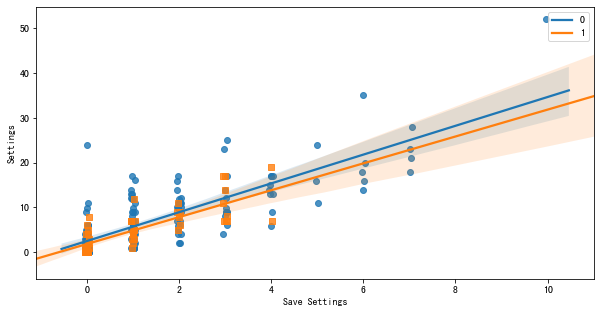

In [15]:
plt.figure(figsize=(10,5))
cancel_type = [['0', 'o'],
               ['1', 's']]
for cancel, marker in cancel_type:
    df_thumbs = df_pages[df_pages['Cancellation Confirmation'] == int(cancel)]
    sns.regplot(data = df_thumbs, x = 'Save Settings', 
                y = 'Settings', 
                x_jitter=0.05,
                y_jitter=0.05,
                marker = marker)  # or plt.scatter
plt.legend(['0','1']);

### 探索用户使用设备或软件 和取消服务关系

结论：
* 使用Ubuntu取消服务偏多、iPad使用人取消服务人相对较少

In [16]:
device_count = df_pages.groupby(['deviceModel', 'Cancellation Confirmation']).size().reset_index(name='count')
# device_counts = device_count.pivot(index='deviceModel', columns = 'Cancellation Confirmation', values='count')

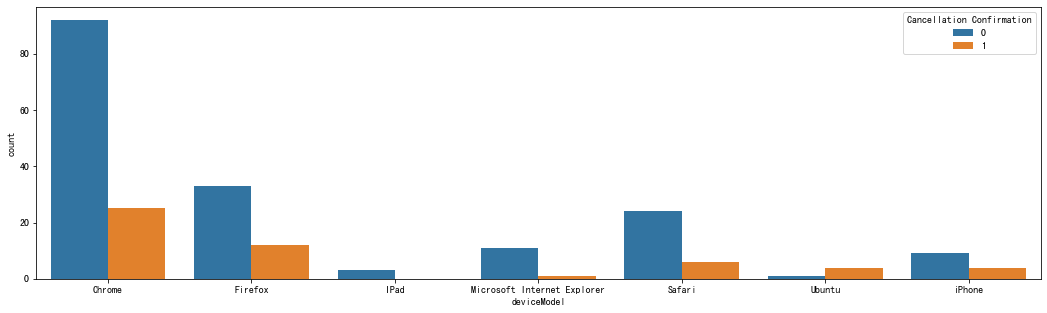

In [18]:
plt.figure(figsize=(18, 5))
sns.barplot(data=device_count, x='deviceModel', y='count', hue='Cancellation Confirmation')

### 取消服务和没取消服务听歌的频率对比

结论
* 取消服务的人明显听歌数量也偏少
* 查看滚动广告越多的，越容易取消服务

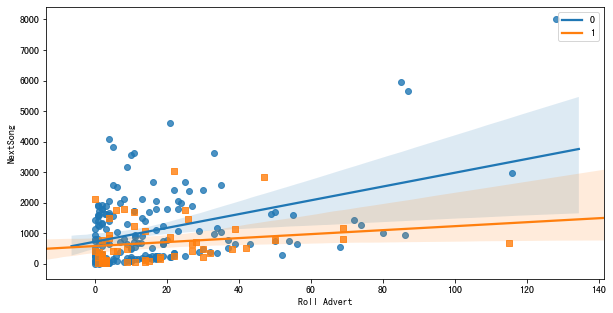

In [19]:
plt.figure(figsize=(10,5))
cancel_type = [['0', 'o'],
               ['1', 's']]
for cancel, marker in cancel_type:
    df_thumbs = df_pages[df_pages['Cancellation Confirmation'] == int(cancel)]
    sns.regplot(data = df_thumbs, x = 'Roll Advert', 
                y = 'NextSong', 
                x_jitter=0.05,
                y_jitter=0.05,
                marker = marker)  # or plt.scatter
plt.legend(['0','1']);

/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(592.1499999999999, 0.5, 'Frequency')

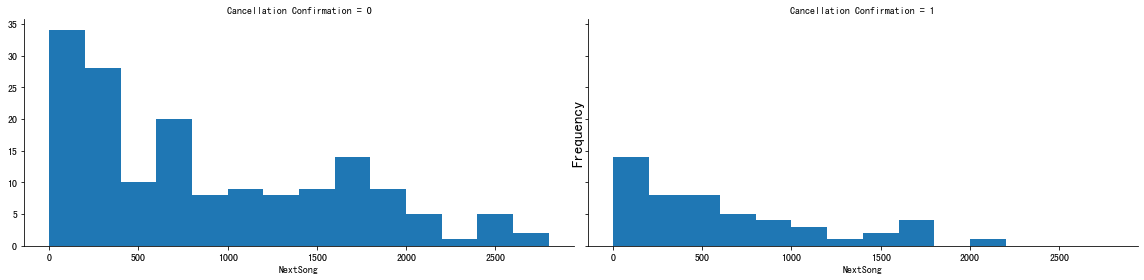

In [20]:
bins_edge = np.arange(0, 3000, 200)

g = sns.FacetGrid(data=df_pages, 
                  col='Cancellation Confirmation', 
                  col_wrap=2,
                 size=4, aspect=2) # 会按 '是否取消服务类型' 拆分子图

# 实用FaceGrid对象的map函数.第一个参数是绘图函数plt.hist, 第二个变量要绘制的 x轴变量名 NextSong
g.map(plt.hist, 'NextSong', bins=bins_edge);
plt.ylabel('Frequency', fontsize=15)


### 取消服务和没取消服务查看广告的频率对比

结论
* 取消服务的人明显查看广告的数量也偏少

Text(592.1499999999999, 0.5, 'Frequency')

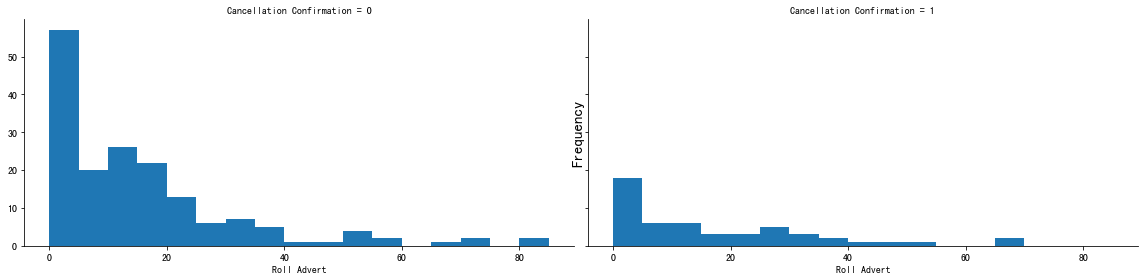

In [21]:
# Roll Advert

bins_edge = np.arange(0, 90, 5)

g = sns.FacetGrid(data=df_pages, 
                  col='Cancellation Confirmation', 
                  col_wrap=2,
                 size=4, aspect=2) # 会按 '是否取消服务类型' 拆分子图

# 实用FaceGrid对象的map函数.第一个参数是绘图函数plt.hist, 第二个变量要绘制的 x轴变量名 NextSong
g.map(plt.hist, 'Roll Advert', bins=bins_edge);
plt.ylabel('Frequency', fontsize=15)

### 'Downgrade  VS  Upgrade' And 'Submit Downgrade  VS  Submit Upgrade' OVER Label (Cancel)

结论
* 根据回归曲线，越少的降级发生越好

/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


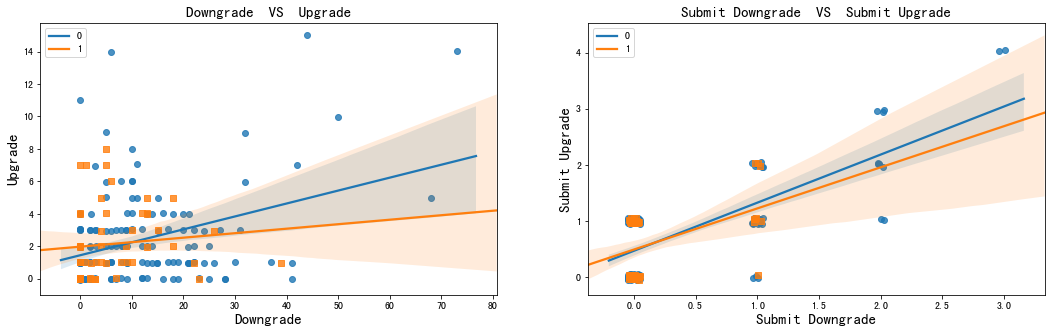

In [22]:

plt.figure(figsize=(18,5))
cancel_type = [['0', 'o'],
               ['1', 's']]
for cancel, marker in cancel_type:
    df_subset = df_pages[df_pages['Cancellation Confirmation'] == int(cancel)]
    
    # first plot
    plt.subplot(121)
    sns.regplot(data = df_subset, x = 'Downgrade', 
                y = 'Upgrade', 
                x_jitter=0.05,
                y_jitter=0.05,
                marker = marker)  # or plt.scatter
    plt.xlabel('Downgrade', fontsize=15)
    plt.ylabel('Upgrade', fontsize=15)
    plt.title('Downgrade  VS  Upgrade',fontsize=15);
    plt.legend(['0','1']);
    
    plt.subplot(122)
    sns.regplot(data = df_subset, x = 'Submit Downgrade', 
                y = 'Submit Upgrade', 
                x_jitter=0.05,
                y_jitter=0.05,
                marker = marker)  # or plt.scatter
    plt.xlabel('Submit Downgrade', fontsize=15)
    plt.ylabel('Submit Upgrade', fontsize=15)
    plt.title('Submit Downgrade  VS  Submit Upgrade',fontsize=15);
    plt.legend(['0','1']);

### 'Thumbs Down' VS 'Thumbs Up'  And 'Add Friend' VS 'Add to Playlist' OVER Label (Cancel)

结论：
* 点赞越少的用户，越倾向于取消服务
* 添加好友和添加歌曲少于20的用户，越可能取消服务
* 添加好友次数越少的用户，越倾向于取消服务

/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/Users/qihengshan/pythonEnv/python374/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


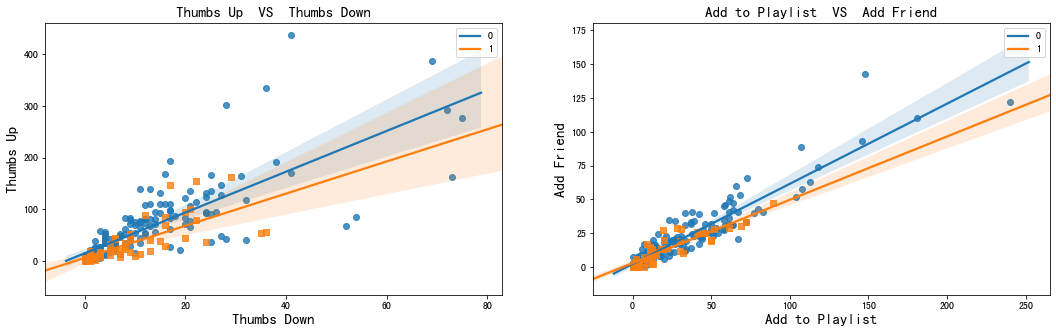

In [23]:
plt.figure(figsize=(18,5))

cancel_type = [['0', 'o'],
               ['1', 's']]

for cancel, marker in cancel_type:
    df_subset = df_pages[df_pages['Cancellation Confirmation'] == int(cancel)]
    # first subplot
    plt.subplot(1,2,1);
    sns.regplot(data=df_subset, x='Thumbs Down', y='Thumbs Up', marker = marker);  # or plt.scatter
    plt.xlabel('Thumbs Down', fontsize=15)
    plt.ylabel('Thumbs Up', fontsize=15)
    plt.title('Thumbs Up  VS  Thumbs Down',fontsize=15);
    plt.legend(['0','1']);
    # second subplot
    plt.subplot(1,2,2);
    sns.regplot(data=df_subset, x='Add to Playlist', y='Add Friend', marker=marker);  # or plt.scatter
    plt.xlabel('Add to Playlist', fontsize=15)
    plt.ylabel('Add Friend', fontsize=15)
    plt.title('Add to Playlist  VS  Add Friend',fontsize=15);
    plt.legend(['0','1']);


### 统计过去N天用户访问page的行为，统计出取消服务的用户

* 最终计算 过去 N 天内出现过的 page 行为数量 占比 (相对于访问总量)。比如: (过去N天内Cancellation Confirmation数量)/(总Cancellation Confirmation数量)

In [24]:
def get_lastNdays_cancel_user(n, total_cancel=52.0):
    max_value = user_log.agg({"ts_date": "max"}).collect()[0][0]
    tmp_df = user_log.where(col("ts_date") > date_sub(lit(max_value), n))
    tmp_df_groupby = tmp_df.groupBy('userId', 'page').agg(count('page').alias('count_page')).sort('userId')
    cancel_count = tmp_df_groupby.filter(col("page") == "Cancellation Confirmation").count()
    print(f"Last {n} days log , cancel user number : {cancel_count}, Cancel_Percentage: {float(cancel_count)/total_cancel}")
    return n, cancel_count

# N 间隔天数 新增取消服务人数画图
def cancel_plot(n, cl):
    minus_list = []
    for i in range(len(cl)):
        if i < len(cl) -1:
            minus_list.append(cl[i+1] - cl[i])
    print(cl)
    pd.Series(minus_list).plot(kind='bar')
    return minus_list

#### 5天一周期、7天一周期查看用户流失情况

In [25]:
def intervalNday_plot(n, max_cancel=52):
    """
    INPUT:
        n: int number. eg: 5
    """
    tmp = []
    for i in range(n, 200, n):
        last_days, cancel_count = get_lastNdays_cancel_user(i)
        tmp.append(cancel_count)
        if cancel_count == max_cancel:
            break
    cancel_plot(n, tmp)

Last 5 days log , cancel user number : 1, Cancel_Percentage: 0.019230769230769232
Last 10 days log , cancel user number : 4, Cancel_Percentage: 0.07692307692307693
Last 15 days log , cancel user number : 7, Cancel_Percentage: 0.1346153846153846
Last 20 days log , cancel user number : 13, Cancel_Percentage: 0.25
Last 25 days log , cancel user number : 14, Cancel_Percentage: 0.2692307692307692
Last 30 days log , cancel user number : 17, Cancel_Percentage: 0.3269230769230769
Last 35 days log , cancel user number : 23, Cancel_Percentage: 0.4423076923076923
Last 40 days log , cancel user number : 26, Cancel_Percentage: 0.5
Last 45 days log , cancel user number : 33, Cancel_Percentage: 0.6346153846153846
Last 50 days log , cancel user number : 41, Cancel_Percentage: 0.7884615384615384
Last 55 days log , cancel user number : 45, Cancel_Percentage: 0.8653846153846154
Last 60 days log , cancel user number : 50, Cancel_Percentage: 0.9615384615384616
Last 65 days log , cancel user number : 52, Ca

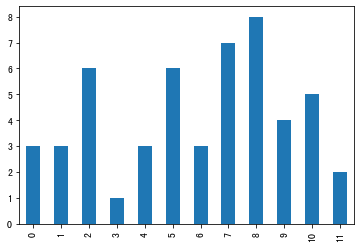

In [26]:
intervalNday_plot(5)

Last 7 days log , cancel user number : 1, Cancel_Percentage: 0.019230769230769232
Last 14 days log , cancel user number : 6, Cancel_Percentage: 0.11538461538461539
Last 21 days log , cancel user number : 13, Cancel_Percentage: 0.25
Last 28 days log , cancel user number : 15, Cancel_Percentage: 0.28846153846153844
Last 35 days log , cancel user number : 23, Cancel_Percentage: 0.4423076923076923
Last 42 days log , cancel user number : 29, Cancel_Percentage: 0.5576923076923077
Last 49 days log , cancel user number : 39, Cancel_Percentage: 0.75
Last 56 days log , cancel user number : 47, Cancel_Percentage: 0.9038461538461539
Last 63 days log , cancel user number : 52, Cancel_Percentage: 1.0
[1, 6, 13, 15, 23, 29, 39, 47, 52]


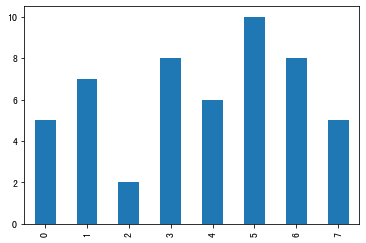

In [27]:
intervalNday_plot(7)

### 对比结果：
* 7天一周期看 过去28天~过去56天之间，取消服务用户最多 达到 32人 (8+6+10+8)/53 = 61.5%
* 5天一周期看，过去的第40天~50天之间，取消服务的用户增量最多 15人（7+8）/ 52 = 28.8%


# 特征工程


## 所有用户访问page页行为汇总

In [28]:
def all_user_page_data(user_log):
    """
    所有时段用户访问page页行为
    
    INPUT:
        user_log: spark dataframe (contain all data)
    
    OUTPUT:
        user_log_groupby_pivot: page actoin to column
        user_labels: contain userId, label （cancel or not cancel value）
    """
    # group by userId,page with location and deviceModel
    user_log_groupby = user_log.groupBy('userId', 'location', 'deviceModel', 'page') \
        .agg(count('page').alias('count_page')) \
        .sort('userId')
    #
    user_log_groupby.createOrReplaceTempView('user_log_groupby_table')
    # privot : row to column for page action
    user_log_groupby_pivot = user_log_groupby.groupBy('userId', 'location', 'deviceModel').pivot('page').max('count_page').fillna(0)
    
    # 提取label列
    user_labels = user_log_groupby_pivot.select('userId', col('Cancellation Confirmation').alias('label'))
    user_log_groupby_pivot = user_log_groupby_pivot.drop(*('Cancellation Confirmation', 'Cancel'))
    
    return user_log_groupby_pivot, user_labels

### 获取过去28天到过去56天的用户行为数据

28天数据包含信息如下
* 137516行数据  (总共278154行行为数据)
* 211名用户行为数据 (总共225名用户，清理Null后)
* 32名取消服务用户 (总共取消服务用户52名)

In [39]:
def subset_user_page_data(user_log, start=56, end = 28):
    max_value = user_log.agg({"ts_date": "max"}).collect()[0][0]
    # 28days56 count() = 46978, cancel user: 15
    user_log_28days56 = user_log.where( col("ts_date") >= date_sub(lit(max_value), start)).where(col("ts_date") <= date_sub(lit(max_value), end) )

    # last 28~56 days page action  group by userId, page
    user_log_28days56_groupby = user_log_28days56.groupBy('userId', 'page') \
        .agg(count('page').alias('count_page')) \
        .sort('userId')

    user_log_28days56_groupby.createOrReplaceTempView('user_log_28days56_groupby_table')

    # user_log_28days56_groupby.filter(col("page") == "Cancellation Confirmation").count()
    # output: 15 

    # 生成page类型为列的表
    user_log_28days56_groupby_pivot = user_log_28days56_groupby.groupBy('userId').pivot('page').max('count_page').fillna(0)

    user_log_28days56_groupby_pivot = user_log_28days56_groupby_pivot.drop(*('Cancellation Confirmation', 'Cancel'))

    return user_log_28days56_groupby, user_log_28days56_groupby_pivot


### 替换列名空格为下划线

* user_log_groupby_pivot 列名中的空格替换成 '_'
* user_log_28days56_groupby_pivot 列名中的空格替换成 '_'，每个列名添加'_28_56'后缀

In [31]:
user_log_groupby_pivot, user_labels = all_user_page_data(user_log)
user_log_28days56_groupby, user_log_28days56_groupby_pivot = subset_user_page_data(user_log, start=56, end = 28)

In [32]:
tmpCol1 = list(map(lambda x: x.replace(" ", "_"), user_log_groupby_pivot.columns))
tmpCol2 = list(map(lambda x: x.replace(" ", "_") + "_28_56", user_log_28days56_groupby_pivot.columns))
# df = df.toDF(*new_column_name_list)
user_log_groupby_pivot = user_log_groupby_pivot.toDF(*tmpCol1)
user_log_28days56_groupby_pivot = user_log_28days56_groupby_pivot.toDF(*tmpCol2)

### 用户注册时长统计（单位：天）

In [33]:
user_use_time = spark.sql("""
        select userId,
            round((max(ts)/1000 - min(registration)/1000)/(24*3600)) as useTime 
            from user_log_table group by userId
        """)

### 标准化数据
相同的标准，标准化数据
* user_log_groupby_pivot, user_log_28days56_groupby_pivot 合并后的除去 (userId, userId_28_56, location, deviceModel)的列

#### user_log_groupby_pivot

In [34]:
cols = user_log_groupby_pivot.columns
cols.remove('userId')
cols.remove('location')
cols.remove('deviceModel')

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), DoubleType())

# Iterating over columns to be scaled
for i in cols:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    user_log_groupby_pivot = pipeline.fit(user_log_groupby_pivot) \
            .transform(user_log_groupby_pivot) \
            .withColumn(i+"_Scaled", unlist(i+"_Scaled")) \
            .drop(*(i, i+"_Vect"))  # 保留原始i列 和i+"_28_56"列 .drop( *(i, i+"_Vect", i+"_28_56") )
    print(f"column: {i} scaled done.")

print("After Scaling :")
user_log_groupby_pivot.show(1)

column: About scaled done.
column: Add_Friend scaled done.
column: Add_to_Playlist scaled done.
column: Downgrade scaled done.
column: Error scaled done.
column: Help scaled done.
column: Home scaled done.
column: Logout scaled done.
column: NextSong scaled done.
column: Roll_Advert scaled done.
column: Save_Settings scaled done.
column: Settings scaled done.
column: Submit_Downgrade scaled done.
column: Submit_Upgrade scaled done.
column: Thumbs_Down scaled done.
column: Thumbs_Up scaled done.
column: Upgrade scaled done.
After Scaling :
+------+----------+-----------+------------+-----------------+----------------------+----------------+------------+-----------+-----------+-------------+---------------+------------------+--------------------+---------------+-----------------------+---------------------+------------------+----------------+--------------+
|userId|  location|deviceModel|About_Scaled|Add_Friend_Scaled|Add_to_Playlist_Scaled|Downgrade_Scaled|Error_Scaled|Help_Scaled|Home_

#### user_log_28days56_groupby_pivot

In [35]:
columns = user_log_28days56_groupby_pivot.columns
columns.remove('userId_28_56')

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),6), DoubleType())

# Iterating over columns to be scaled
for i in columns:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    user_log_28days56_groupby_pivot = pipeline.fit(user_log_28days56_groupby_pivot) \
            .transform(user_log_28days56_groupby_pivot) \
            .withColumn(i+"_Scaled", unlist(i+"_Scaled")) \
            .drop(*(i, i+"_Vect"))  # 保留原始i列 和i+"_28_56"列 .drop( *(i, i+"_Vect", i+"_28_56") )
    print(f"column: {i} scaled done.")

print("After Scaling :")
user_log_28days56_groupby_pivot.show(1)

column: About_28_56 scaled done.
column: Add_Friend_28_56 scaled done.
column: Add_to_Playlist_28_56 scaled done.
column: Downgrade_28_56 scaled done.
column: Error_28_56 scaled done.
column: Help_28_56 scaled done.
column: Home_28_56 scaled done.
column: Logout_28_56 scaled done.
column: NextSong_28_56 scaled done.
column: Roll_Advert_28_56 scaled done.
column: Save_Settings_28_56 scaled done.
column: Settings_28_56 scaled done.
column: Submit_Downgrade_28_56 scaled done.
column: Submit_Upgrade_28_56 scaled done.
column: Thumbs_Down_28_56 scaled done.
column: Thumbs_Up_28_56 scaled done.
column: Upgrade_28_56 scaled done.
After Scaling :
+------------+------------------+-----------------------+----------------------------+----------------------+------------------+-----------------+-----------------+-------------------+---------------------+------------------------+--------------------------+---------------------+-----------------------------+---------------------------+---------------

#### user_use_time

In [36]:
# VectorAssembler Transformation - Converting column to vector type
i = 'useTime'
assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

# MinMaxScaler Transformation
scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

# Pipeline of VectorAssembler and MinMaxScaler
pipeline = Pipeline(stages=[assembler, scaler])

# Fitting pipeline on dataframe
user_use_time = pipeline.fit(user_use_time) \
        .transform(user_use_time) \
        .withColumn(i+"_Scaled", unlist(i+"_Scaled")) \
        .drop( *(i, i+"_Vect") )  # 保留原始i列 和i+"_28_56"列 .drop( *(i, i+"_Vect", i+"_28_56") )

print("After Scaling :")
user_use_time.show(1)

After Scaling :
+------+--------------+
|userId|useTime_Scaled|
+------+--------------+
|100010|       0.21875|
+------+--------------+
only showing top 1 row



#### 连接dataframe
user_log_groupby_pivot 、user_log_28days56_groupby_pivot、user_use_time

In [37]:
user_page_pivot = user_log_groupby_pivot.join(user_log_28days56_groupby_pivot, 
                                              user_log_groupby_pivot.userId == user_log_28days56_groupby_pivot.userId_28_56) # how='inner'
user_page_pivot = user_page_pivot.join(user_use_time, on=['userId']).drop('userId_28_56')

## 过去28天至过去56天列对全数据量占比统计

In [41]:
# 生成page类型为列的表
user_log_groupby_pivot_tmp = user_log_groupby \
    .groupBy('userId', 'location', 'deviceModel') \
    .pivot('page').max('count_page').fillna(0)

user_log_28days56_groupby_pivot_tmp = user_log_28days56_groupby \
    .groupBy('userId') \
    .pivot('page').max('count_page').fillna(0)
# rename column name
user_log_groupby_pivot_tmp = user_log_groupby_pivot_tmp \
    .drop(*('Cancel', 'Cancellation Confirmation')) \
    .toDF(*tmpCol1)
user_log_28days56_groupby_pivot_tmp = user_log_28days56_groupby_pivot_tmp \
    .drop(*('Cancel', 'Cancellation Confirmation')) \
    .toDF(*tmpCol2)

# 连接 dataframe 连接后: 
user_page_pivot_tmp = user_log_groupby_pivot_tmp.join(
    user_log_28days56_groupby_pivot_tmp, 
    user_log_groupby_pivot_tmp.userId == user_log_28days56_groupby_pivot_tmp.userId_28_56) # how='full_outer'

user_page_pivot_tmp = user_page_pivot_tmp.drop('userId_28_56', 'location', 'deviceModel')

# normal data
new_cols = user_log_28days56_groupby_pivot_tmp.columns
new_cols.remove('userId_28_56')
# Iterating over columns to be scaled
for c in new_cols:
    init_col = c[:-6]
    cMaxValue = user_page_pivot_tmp.agg({init_col: "max"}).collect()[0][0]
    cMinValue = user_page_pivot_tmp.agg({init_col: "min"}).collect()[0][0]
    
    # tmpCol1 = list(map(lambda x: x.replace(" ", "_"), user_log_groupby_pivot.columns))
    doNormal = udf(lambda x: round(float(x-cMinValue)/float(cMaxValue-cMinValue),6), DoubleType())
    
    user_page_pivot_tmp = user_page_pivot_tmp.withColumn(c+"_Pct", doNormal(c)).drop(*(init_col, c))
    print(f"column: {c} scaled done. MaxValue: {cMaxValue}, MinValue: {cMinValue} ")

print("After Scaling :")
user_page_pivot_tmp.show(1)

column: About_28_56 scaled done. MaxValue: 25, MinValue: 0 
column: Add_Friend_28_56 scaled done. MaxValue: 143, MinValue: 0 
column: Add_to_Playlist_28_56 scaled done. MaxValue: 240, MinValue: 0 
column: Downgrade_28_56 scaled done. MaxValue: 73, MinValue: 0 
column: Error_28_56 scaled done. MaxValue: 7, MinValue: 0 
column: Help_28_56 scaled done. MaxValue: 46, MinValue: 0 
column: Home_28_56 scaled done. MaxValue: 355, MinValue: 0 
column: Logout_28_56 scaled done. MaxValue: 124, MinValue: 0 
column: NextSong_28_56 scaled done. MaxValue: 8002, MinValue: 8 
column: Roll_Advert_28_56 scaled done. MaxValue: 128, MinValue: 0 
column: Save_Settings_28_56 scaled done. MaxValue: 10, MinValue: 0 
column: Settings_28_56 scaled done. MaxValue: 52, MinValue: 0 
column: Submit_Downgrade_28_56 scaled done. MaxValue: 3, MinValue: 0 
column: Submit_Upgrade_28_56 scaled done. MaxValue: 4, MinValue: 0 
column: Thumbs_Down_28_56 scaled done. MaxValue: 75, MinValue: 0 
column: Thumbs_Up_28_56 scaled d

In [42]:
user_page_pivot_all = user_page_pivot.join(user_page_pivot_tmp, on=['userId'])

## one-hot 设备信息 和 位置列

* location
* deviceModel

In [43]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator

# StringIndexes first
stringIndexer = [StringIndexer(inputCol=column, outputCol=column+"Idx").fit(user_page_pivot_all) for column in ["location", "deviceModel"] ]
pipeline = Pipeline(stages=stringIndexer)
df_user_page = pipeline.fit(user_page_pivot_all).transform(user_page_pivot_all)

# OneHot
encoder = OneHotEncoderEstimator(inputCols=["locationIdx", "deviceModelIdx"], 
                        outputCols=["locationVec", "deviceModelVec"])
model = encoder.fit(df_user_page)
df_user_page = model.transform(df_user_page)
# drop old col
df_user_page = df_user_page.drop(*("location", "deviceModel", "locationIdx", "deviceModelIdx"))
df_user_page.select("locationVec", "deviceModelVec").show(5)

+----------------+--------------+
|     locationVec|deviceModelVec|
+----------------+--------------+
|(109,[25],[1.0])| (6,[3],[1.0])|
| (109,[5],[1.0])| (6,[3],[1.0])|
|(109,[74],[1.0])| (6,[0],[1.0])|
|(109,[46],[1.0])| (6,[0],[1.0])|
|(109,[71],[1.0])| (6,[0],[1.0])|
+----------------+--------------+
only showing top 5 rows



# 建模
将完整数据集分成训练集、测试集和验证集。测试几种机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率挑选出表现最好的模型。因为流失顾客数据集很小，建议选用 F1 score 作为优化指标。

### 合并features和label

In [45]:
df_user_page = df_user_page.join(user_labels, on=['userId'])

In [46]:
feature_cols = df_user_page.columns
feature_cols.remove('userId')
feature_cols.remove('label')

### 合并特征列为 features 向量

In [47]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features")

df_user_page = assembler.transform(df_user_page)
df_user_page.select("features", "label").show(2, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### 建模、训练模型、预测准确率

In [48]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
# data = sqlContext.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_user_page)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_user_page)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = df_user_page.randomSplit([0.8, 0.2])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=20, stepSize=0.01)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error # (f1|weightedPrecision|weightedRecall|accuracy)
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")  # F1  accuracy
f1_score = evaluator.evaluate(predictions)

print(f"f1 score: {f1_score}")

# accuracy = evaluator.evaluate(predictions)
# print("Test Error = %g" % (1.0 - accuracy))
# gbtModel = model.stages[2]
# print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|(167,[0,1,2,5,6,7...|
|       1.0|         0.0|(167,[0,1,2,3,4,5...|
|       0.0|         1.0|(167,[1,2,3,5,6,7...|
|       1.0|         0.0|(167,[1,2,5,6,7,8...|
|       0.0|         0.0|(167,[0,1,2,3,4,5...|
+----------+------------+--------------------+
only showing top 5 rows

f1 score: 0.7262626262626263


In [50]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")  # F1  accuracy
accuracy = evaluator.evaluate(predictions)
print(f"accuracy : {accuracy}")

accuracy : 0.7333333333333333


In [49]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")  # F1  accuracy
f1_score = evaluator.evaluate(predictions)
f1_score

0.7262626262626263

In [51]:
model.save("./trained_model_f1_72_ac_73.mdl")
# path = tempfile.mkdtemp()
# >>> lrm.save(sc, path)
# >>> sameModel = LogisticRegressionModel.load(sc, path)

# 结论

## 反思

经过数据清洗、数据探索、新特征创建、建模、模型评估，最终可以根据用户的行为，提前预测到用户是否会取消服务，可以提前给将要取消服务的用户打折优惠，以留住这些用户。然后改进产品，增加用户粘性，从而打造一个成功的产品。

整个流程最喜欢的部分是：探索的可视化、建模 部分。可视化可以发现特征之间潜在的规律；建模则可以利用这些规律做出预测。

## 模型改进

### f1 score得分较低原因分析
* 数据样本较少
* 特征提取不够精细
* 未使用Kfold交叉检验
* 未调参
